## Importing Data

In [ ]:
# Google Colab .zip File
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/'My Drive'/image_classification_data.zip .
!unzip -q -o image_classification_data.zip
!rm image_classification_data.zip
!mkdir image_classification_data

# Move Zip Contents to Folder
!mv data_labels_extraData.csv image_classification_data
!mv data_labels_mainData.csv image_classification_data
!mv patch_images image_classification_data
!rm -r sample_data

In [2]:
# OR Local .zip File (uncomment)

# import zipfile
# with zipfile.ZipFile('./image_classification_data.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

data = pd.read_csv('./image_classification_data/data_labels_mainData.csv')

extra_data = pd.read_csv('./image_classification_data/data_labels_extraData.csv')

combined_isCancer_data = pd.concat([data, extra_data])
combined_isCancer_data.head()


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0.0,0
1,22406,1,22406.png,fibroblast,0.0,0
2,22407,1,22407.png,fibroblast,0.0,0
3,22408,1,22408.png,fibroblast,0.0,0
4,22409,1,22409.png,fibroblast,0.0,0


## EDA

### Data Overview


#### Data Types

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


Used for model 2 on our classification of cell type.

In [ ]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB


Used to add data points to our main data to further improve our cancerous cell classification.

In [ ]:
combined_isCancer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20280 entries, 0 to 10383
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   InstanceID    20280 non-null  int64  
 1   patientID     20280 non-null  int64  
 2   ImageName     20280 non-null  object 
 3   cellTypeName  9896 non-null   object 
 4   cellType      9896 non-null   float64
 5   isCancerous   20280 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


Used for model 1 on our classification of cancerous cells.

## Feature Analysis

### Target Feature Balance

#### Class Balance - Is Cancerous

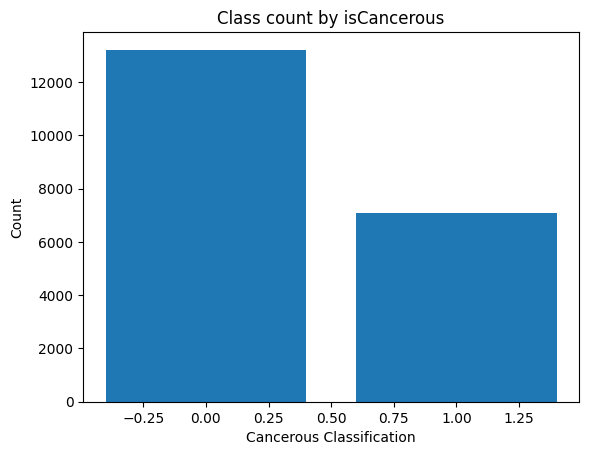

In [ ]:
isCancerousCount = combined_isCancer_data['isCancerous'].value_counts()

plt.bar(isCancerousCount.index, isCancerousCount.values)
plt.xlabel('Cancerous Classification')
plt.ylabel('Count')
plt.title('Class count by isCancerous')
plt.show()

#### Class Balance - Cell Type

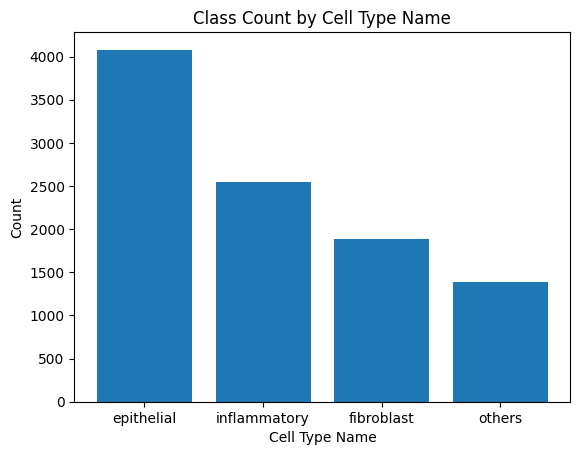

In [ ]:
import matplotlib.pyplot as plt

cellTypeNameCount = combined_isCancer_data['cellTypeName'].value_counts()

plt.bar(cellTypeNameCount.index, cellTypeNameCount.values)
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.title('Class Count by Cell Type Name')
plt.show()

Though we observe a class imbalance in cell type and cancerous classes, due to the sufficient size of the dataset and the number of instances from each class the model will generally still learn from the minority class hence we will withdraw from attempting to correct the balance.
It may also be the case that the class imbalance is a natural characteristic of the data.

### Missing Features

#### Model 1 Dataset

In [ ]:
missing_values = combined_isCancer_data.isnull().sum()

# Display the percentage of missing values
print("Missing Values")
print(missing_values)

Missing Values
InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
dtype: int64


#### Model 2 Dataset

In [ ]:
missing_values = data.isnull().sum()

# Display the percentage of missing values
print("Missing Values")
print(missing_values)

Missing Values
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


Observing above, our combined dataset does not contain values for the cell type feature so it cannot be used when we produce our second model that classifies cell type. However, this combined dataset will be useful as it provides us with greater data points to classify our binary feature, isCancerous, in model 1.

### Unique Values

In [ ]:
print("Unique patients:", combined_isCancer_data["patientID"].nunique())
print("Unique image categories:", combined_isCancer_data["ImageName"].nunique())
print("Unique cell types:", combined_isCancer_data["cellTypeName"].nunique())
print("Unique cellType values:", combined_isCancer_data["cellType"].nunique())

Unique patients: 98
Unique image categories: 20280
Unique cell types: 4
Unique cellType values: 4


### Correlation between Cell Type and Cancerous Cell

<Figure size 1000x600 with 0 Axes>

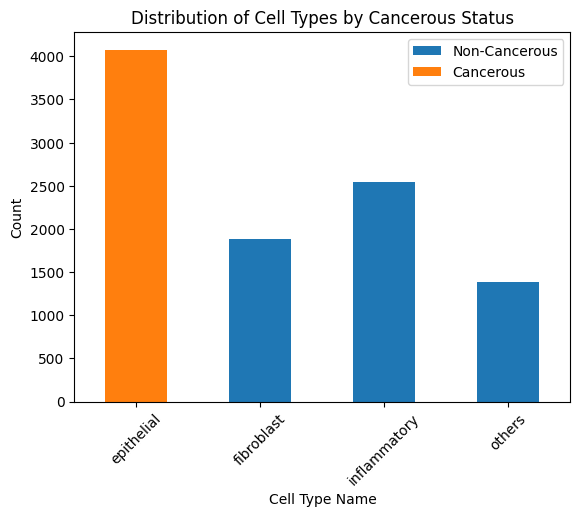

In [ ]:
cell_type_cancer_counts = combined_isCancer_data.groupby(['cellTypeName', 'isCancerous']).size().unstack()

plt.figure(figsize=(10, 6))
cell_type_cancer_counts.plot(kind='bar', stacked=True)

plt.title('Distribution of Cell Types by Cancerous Status')
plt.ylabel('Count')
plt.xlabel('Cell Type Name')
plt.legend(['Non-Cancerous', 'Cancerous'])

# Flip Labels
plt.xticks(rotation=45)
plt.show()

### Encoding Categorical

The cellType feature is an encoded version of the cellTypeName hence we don't need to perform further encoding. We will however verify if the values map as expected


In [ ]:
correlation_dict = {'fibroblast': 0, 'inflammatory': 1, 'epithelial': 2, 'others': 3}

# Produce Expected CellTypeValues using Dictionary
data['expectedCellType'] = data['cellTypeName'].map(correlation_dict)

# Compare Expected with Actual CellType Values
data['results'] = data['cellType'] == data['expectedCellType']

# Print Whether CellType Maps to Expected Value
if(data['results'].sum().all() == True): 
    print("Consistent Mapping of CellType Values")
else:
    print("Inconsistent Mapping of CellType Values")

Consistent Mapping of CellType Values


# Model 1 - isCancerous


### Splitting Data

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(combined_isCancer_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


### Diagnostic Tool

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()    

### Data Generator 

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 2 classes.
Found 4056 validated image filenames belonging to 2 classes.


### Baseline Model

In [ ]:
INPUT_DIM = (27,27,3) # 26x26 Pixel Images, 3 Channels (RGB) 
HIDDEN_LAYER_DIM = 256 # Hyper Parameter we can Tune Later
OUTPUT_CLASSES = 2 

Why is sigmoid good for binary classification? compared to other??

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


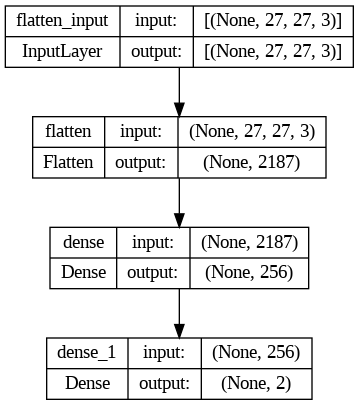

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50


<ipython-input-17-d282d76f89ea>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


381/381 [==============================] - 11s 26ms/step - loss: 0.6199 - categorical_accuracy: 0.6510 - val_loss: 0.5904 - val_categorical_accuracy: 0.6573
Epoch 2/50
381/381 [==============================] - 9s 23ms/step - loss: 0.5737 - categorical_accuracy: 0.6672 - val_loss: 0.5464 - val_categorical_accuracy: 0.7091
Epoch 3/50
381/381 [==============================] - 10s 27ms/step - loss: 0.5303 - categorical_accuracy: 0.7311 - val_loss: 0.5038 - val_categorical_accuracy: 0.7557
Epoch 4/50
381/381 [==============================] - 16s 42ms/step - loss: 0.4897 - categorical_accuracy: 0.7868 - val_loss: 0.4657 - val_categorical_accuracy: 0.8173
Epoch 5/50
251/381 [==================>...........] - ETA: 2s - loss: 0.4579 - categorical_accuracy: 0.8134

KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### VGG 1 - Deep Learning Model

In [ ]:
import tensorflow as tf

model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_VGG_1.summary()

NameError: ignored

In [ ]:
tf.keras.utils.plot_model(model_VGG_1, show_shapes=True)

In [ ]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
history2 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

In [ ]:
plot_learning_curve(history2.history['loss'], history2.history['val_loss'], 
                    history2.history['binary_accuracy'], history2.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

### VGG 2 - Preventing Overfitting

In [ ]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['binary_accuracy'])

In [ ]:
history3 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=30, verbose=1)

Epoch 1/50


<ipython-input-20-695ed4e5378e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


381/381 [==============================] - 97s 250ms/step - loss: 0.5757 - binary_accuracy: 0.7380 - val_loss: 0.4121 - val_binary_accuracy: 0.8226
Epoch 2/50
 25/381 [>.............................] - ETA: 1:08 - loss: 0.4456 - binary_accuracy: 0.8073

KeyboardInterrupt: ignored

In [ ]:
plot_learning_curve(history3.history['loss'], history3.history['val_loss'], 
                    history3.history['binary_accuracy'], history3.history['val_binary_accuracy'], 
                    metric_name='Accuracy')

# Model Two - Classify Cell Type

## Load the Data

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


## VGG Model for cellTye

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [ ]:
INPUT_DIM = (27,27,3) # 26x26 Pixel Images, 3 Channels (RGB) 
OUTPUT_CLASSES = 4

In [ ]:
from tensorflow.keras import regularizers

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4 
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', 
                          kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history4 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50


<ipython-input-37-e14b3466e5c4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)


186/186 [==============================] - 123s 647ms/step - loss: 1.5366 - categorical_accuracy: 0.4154 - val_loss: 1.3632 - val_categorical_accuracy: 0.4093
Epoch 2/50
186/186 [==============================] - 119s 641ms/step - loss: 1.3316 - categorical_accuracy: 0.4174 - val_loss: 1.3397 - val_categorical_accuracy: 0.4093
Epoch 3/50
186/186 [==============================] - 118s 635ms/step - loss: 1.1968 - categorical_accuracy: 0.4772 - val_loss: 1.3616 - val_categorical_accuracy: 0.4598
Epoch 4/50
186/186 [==============================] - 118s 634ms/step - loss: 1.0790 - categorical_accuracy: 0.5405 - val_loss: 1.1235 - val_categorical_accuracy: 0.5124
Epoch 5/50
186/186 [==============================] - 118s 634ms/step - loss: 1.0208 - categorical_accuracy: 0.5631 - val_loss: 0.9517 - val_categorical_accuracy: 0.5937
Epoch 6/50
186/186 [==============================] - 118s 634ms/step - loss: 0.9731 - categorical_accuracy: 0.5922 - val_loss: 0.9262 - val_categorical_accuracy

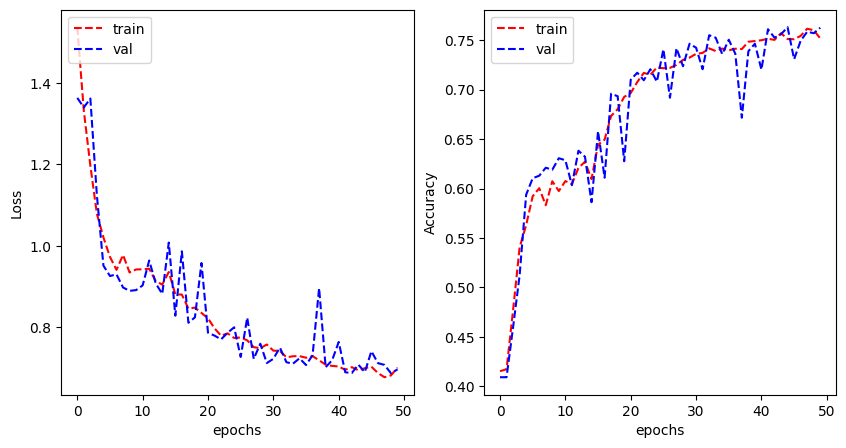

In [ ]:
plot_learning_curve(history4.history['loss'], history4.history['val_loss'], 
                    history4.history['categorical_accuracy'], history4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Transfer learning - Using Extra Data File to assist classifynig cell-tye

In [ ]:
model_VGG_3.save_weights('model_weights.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

extra_generator = extra_datagen.flow_from_dataframe(
    extra_data,
    directory='/content/image_classification_data/patch_images',
    x_col='ImageName',
    target_size=(27, 27),
    class_mode=None,
    batch_size=32,
    shuffle=False)

Found 10384 validated image filenames.


In [ ]:
model_VGG_3.load_weights('model_weights.h5')
predictions = model_VGG_.predict(extra_generator)
predicted_classes = np.argmax(predictions, axis=1)

extra_data['cellType'] = predicted_classes
extra_data.head()

325/325 [==============================] - 42s 129ms/step


,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,1
2,12683,61,12683.png,0,0
3,12684,61,12684.png,0,0
4,12685,61,12685.png,0,0


In [ ]:
combined_df = pd.concat([data, extra_data])
combined_df.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(combined_df, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 12168 validated image filenames belonging to 4 classes.
Found 4056 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras import regularizers

reg_lambda = 0.001

model_VGG_4 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', 
                          kernel_regularizer=regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [ ]:
model_VGG_4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
history5 = model_VGG_4.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)

Epoch 1/20


<ipython-input-51-8bfd7f525a8d>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history5 = model_VGG_4.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1)


381/381 [==============================] - 188s 487ms/step - loss: 1.1810 - categorical_accuracy: 0.5731 - val_loss: 0.7474 - val_categorical_accuracy: 0.7562
Epoch 2/20
381/381 [==============================] - 186s 486ms/step - loss: 0.7557 - categorical_accuracy: 0.7464 - val_loss: 0.6845 - val_categorical_accuracy: 0.7717
Epoch 3/20
381/381 [==============================] - 190s 500ms/step - loss: 0.6505 - categorical_accuracy: 0.7835 - val_loss: 0.6675 - val_categorical_accuracy: 0.7747
Epoch 4/20
381/381 [==============================] - 189s 496ms/step - loss: 0.6534 - categorical_accuracy: 0.7793 - val_loss: 0.6735 - val_categorical_accuracy: 0.7759
Epoch 5/20
381/381 [==============================] - 181s 475ms/step - loss: 0.6292 - categorical_accuracy: 0.7905 - val_loss: 0.5693 - val_categorical_accuracy: 0.8136
Epoch 6/20
381/381 [==============================] - 189s 497ms/step - loss: 0.5743 - categorical_accuracy: 0.8125 - val_loss: 0.5603 - val_categorical_accuracy

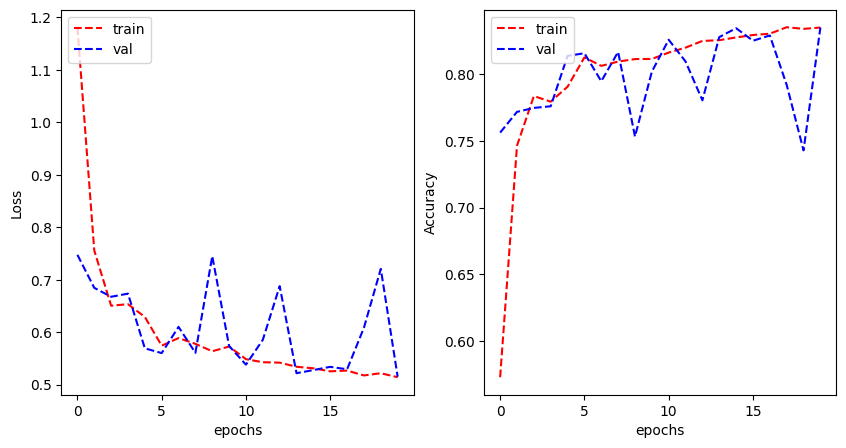

In [ ]:
plot_learning_curve(history5.history['loss'], history5.history['val_loss'], 
                    history5.history['categorical_accuracy'], history5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Testing

## Model 1

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

testing_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = testing_generator.labels

# Generate predictions using the model
y_pred = model_VGG_2.predict(testing_generator)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Model 2

In [ ]:
import tensorflow as tf
from tensorflow import keras

model_VGG_3 = keras.models.load_model("/content/drive/MyDrive/model_VGG_3")

In [ ]:
test_data['cellType'] = test_data['cellType'].astype('str')

# Scale the Image Pixel Values from 0-1
# Both the Training and Testing Set is Scaled in the Same Way
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 4056 validated image filenames belonging to 4 classes.


127/127 [==============================] - 15s 116ms/step


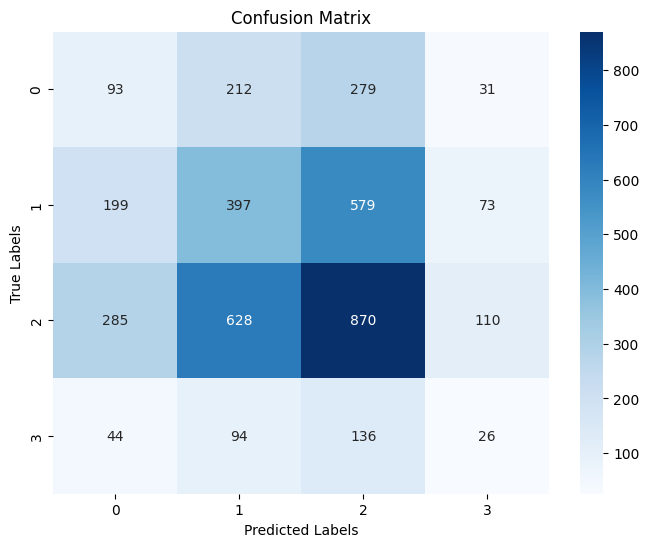

Precision: 0.34033044452568445
Recall: 0.34171597633136097
F1 Score: 0.34082254423700853


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


true_labels = test_generator.labels

# Generate predictions using the model
y_pred = model_VGG_4.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)

# Calculate confusion matrix
cm = confusion_matrix(true_labels, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(true_labels, y_pred_classes, average="weighted")
recall = recall_score(true_labels, y_pred_classes, average="weighted")
f1 = f1_score(true_labels, y_pred_classes, average="weighted")

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)